In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install transformers datasets optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import re

import numpy as np
import torch

In [4]:
from transformers import BertTokenizer, TFBertModel, BertModel, AutoTokenizer, AutoModel, AutoModelForSequenceClassification

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import BertTokenizer, BertModel

import numpy as np

import time
import random
import functools

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader


In [8]:
import seaborn as sns
import itertools
from matplotlib import pyplot as plt
import pandas as pd

In [9]:
def parse_ann_file(text):
    """
    Парсинг файлов анотации
    """
    text = list(filter(lambda x: x!='', text.split('\n')))
    text = [i.split('\t') for i in text]
    text = [[i[1].split(), i[2]] for i in text]
    text = [{'name': i[0][0], 'start': int(i[0][1]), 'end': int(i[0][-1]), 'text': i[1]} for i in text]
    return text 

In [10]:
def return_all_files_texts(prefix_file='./CO_fold/'):
    """
    Закачка документов в буфер памяти
    """
    file_names = os.listdir(prefix_file)
    text_file_list = []
    annotation_file_list = []
    for i in file_names:
        if '.txt' == i[-4:]:
            with open(prefix_file+i) as file:
                 text_file_list.append(file.read())
            with open(prefix_file+i[:-4]+'.ann') as file:
                 annotation_file_list.append(file.read())
    return text_file_list, annotation_file_list

In [11]:
def replace_all(text, dic):
    """
    Множественная замена в строке
    """
    for i, j in dic.items():
        text = text.replace(i, j)
    return text
def harmless_clean(text):
    dict_for_repl = {
                     '{':' ',
                     '}':' ',
                     '\n' : ' '
                    }
    return replace_all(text, dict_for_repl)
    
def soft_clean(text):
    """
    очистка текста от операторов, которые не влияют на предложения
    """
    reg = r'(\\)(\w+)(=\w+|\W*|(\[\w+\])+(\{\w+\})+|(\{\w+\}+)+)\s*\n*|((\\)(\w+))+\s*\n|(\%+\s*\n)'
    dict_for_repl = {'a.k.a.': 'aka', 'e.g.':'eg', 'resp.':'resp', 't.s.':'ts', 't.i.': 'ti'}
    cleaned = text.split('\n')
    cleaned = list(filter(lambda x: not re.fullmatch(reg, x), cleaned))
    return replace_all(' '.join(cleaned).lower(), dict_for_repl)
def start_of_text(raw_text, start_of_raw):
    """
    возвращает текст с начала содержания статьи
    """
    return raw_text[raw_text.find(start_of_raw):]
def add_clean(text):
    """
    дополнительная очистка и подготовка датасета
    """
    dict_for_repl = {'}_{':'_',
                     '\\{':' ',
                     '\\}':' ',
#                      '{':' ',
#                      '}':' ',
                     '$': ' $ ',
                     ' \\ ':' ',
                     '\[':' \[ ',
                     '\]':' \] ',
#                      '\n' : '',
                     ',': ''
                    }
    return re.sub(' +', ' ', replace_all(text, dict_for_repl))

In [12]:
text_file_list, annotation_file_list = return_all_files_texts('/content/drive/MyDrive/mlp/data/')

In [13]:
labels = {'None' : 'none', 'Object' : 'object', 'Symbol' : 'symbol'}

In [14]:
def parse_sentence(sent, offset):
    sent = harmless_clean(sent)+' '
    words = []
    current = sent.find(' ')
    last = 0
    while current != -1:
        word = sent[last:last+current]
        clean = soft_clean(word)
        clean = add_clean(clean).split(' ')
        clean = list(filter(None, clean))
        if len(clean) > 0:
            for cleaned in clean:
                words.append({'word' : cleaned, 'begin' : offset+last, 'end' : offset + last + current, 'label' : labels['None']})

        last += current + 1
        current = sent[last:].find(' ')
    return words

In [15]:
class Sentence:
    def __init__(self, description):
        self.text = description['text']
        self.start = description['start']
        self.end = description['end']
        self.words = parse_sentence(self.text, self.start)
    def add_label(self, ann):
        if ann['name'] not in ['Object', 'Symbol']:
            return
        # check if start and end match
        start = ann['start']
        end = ann['end']
        if start < self.start or end > self.end:
            return
        
        # update start and end, because they differ in .ann file
        start = self.text.find(ann['text']) + self.start
        end = start + len(ann['text'])
        
        for word in self.words:
            if word['begin'] >= start and word['end'] <= end:
                word['label'] = labels[ann['name']]

In [16]:
sentences = []

for ann_file in annotation_file_list:
  parsed_ann = parse_ann_file(ann_file)
  descriptions = list(filter(lambda x: x['name']=='Description', parsed_ann))
  objects_and_symbols = list(filter(lambda x: x['name']!='Description', parsed_ann))

  file_sentences = []
  for description in descriptions:
      file_sentences.append(Sentence(description))

  for annotation in objects_and_symbols:
      for sentence in file_sentences:
          sentence.add_label(annotation)

  sentences.extend(file_sentences)


In [17]:
mathbert_tokenizer = AutoTokenizer.from_pretrained('tbs17/MathBERT')

In [18]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [19]:
def align_tokenizations(sentences, taggings, tokenizer):
  bert_tokenized_sentences = []
  aligned_taggings = []

  for sentence, tagging in zip(sentences, taggings):
    bert_tokenized_sentence = tokenizer.tokenize(' '.join(sentence))

    aligned_tagging = []
    current_word = ''
    index = 0 # index of current word in sentence and tagging
    for token in bert_tokenized_sentence:
      current_word += re.sub(r'^##', '', token) # recompose word with subtoken
      sentence[index] = sentence[index].replace('\xad', '')

      assert token == '[UNK]' or sentence[index].startswith(current_word)

      if token == '[UNK]' or sentence[index] == current_word: # if we completed a word
        current_word = ''
        aligned_tagging.append(tagging[index])
        index += 1
      else: # otherwise insert padding
        aligned_tagging.append('<pad>')

    assert len(bert_tokenized_sentence) == len(aligned_tagging)

    bert_tokenized_sentences.append(bert_tokenized_sentence)
    aligned_taggings.append(aligned_tagging)

  return bert_tokenized_sentences, aligned_taggings

In [20]:
words = [[word['word'] for word in sentence.words] for sentence in sentences]
labels = [[word['label'] for word in sentence.words] for sentence in sentences]
train_sentences, test_sentences, train_taggings, test_taggings = train_test_split(words, labels, test_size=0.2)


bert_train_tokenized_sentences, bert_train_aligned_taggings = align_tokenizations(train_sentences, train_taggings, bert_tokenizer)
bert_valid_tokenized_sentences, bert_valid_aligned_taggings = align_tokenizations(test_sentences, test_taggings, bert_tokenizer)

mathbert_train_tokenized_sentences, mathbert_train_aligned_taggings = align_tokenizations(train_sentences, train_taggings, mathbert_tokenizer)
mathbert_valid_tokenized_sentences, mathbert_valid_aligned_taggings = align_tokenizations(test_sentences, test_taggings, mathbert_tokenizer)

# print(bert_train_tokenized_sentences[0])
# print(bert_train_aligned_taggings[0])

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import collections

label_vocab = collections.defaultdict(lambda: len(label_vocab))
label_vocab['<pad>'] = 0

def convert_to_ids(sentences, taggings, tokenizer):
  sentences_ids = []
  taggings_ids = []
  for sentence, tagging in zip(sentences, taggings):
    sentence_tensor = torch.tensor(tokenizer.convert_tokens_to_ids(['[CLS]'] + sentence + ['SEP'])).long()
    tagging_tensor = torch.tensor([0] + [label_vocab[tag] for tag in tagging] + [0]).long()

    sentences_ids.append(sentence_tensor.to(device))
    taggings_ids.append(tagging_tensor.to(device))
  return sentences_ids, taggings_ids

bert_train_sentences_ids, bert_train_taggings_ids = convert_to_ids(bert_train_tokenized_sentences, bert_train_aligned_taggings, bert_tokenizer)
bert_valid_sentences_ids, bert_valid_taggings_ids = convert_to_ids(bert_valid_tokenized_sentences, bert_valid_aligned_taggings, bert_tokenizer)

mathbert_train_sentences_ids, mathbert_train_taggings_ids = convert_to_ids(mathbert_train_tokenized_sentences, mathbert_train_aligned_taggings, mathbert_tokenizer)
mathbert_valid_sentences_ids, mathbert_valid_taggings_ids = convert_to_ids(mathbert_valid_tokenized_sentences, mathbert_valid_aligned_taggings, mathbert_tokenizer)

In [22]:
from torch.utils.data import Dataset

class TaggingDataset(Dataset):
  def __init__(self, sentences, taggings):
    assert len(sentences) == len(taggings)
    self.sentences = sentences
    self.taggings = taggings

  def __getitem__(self, i):
    return self.sentences[i], self.taggings[i]

  def __len__(self):
    return len(self.sentences)

In [23]:
def collate_fn(items):
  max_len = max(len(item[0]) for item in items)

  sentences = torch.zeros((len(items), max_len), device=items[0][0].device).long().to(device)
  taggings = torch.zeros((len(items), max_len)).long().to(device)

  for i, (sentence, tagging) in enumerate(items):
    sentences[i][0:len(sentence)] = sentence
    taggings[i][0:len(tagging)] = tagging

  return sentences, taggings

In [24]:
batch_size = 16

bert_train_loader = DataLoader(TaggingDataset(bert_train_sentences_ids, bert_train_taggings_ids), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
bert_valid_loader = DataLoader(TaggingDataset(bert_valid_sentences_ids, bert_valid_taggings_ids), batch_size=batch_size, collate_fn=collate_fn)

mathbert_train_loader = DataLoader(TaggingDataset(mathbert_train_sentences_ids, mathbert_train_taggings_ids), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
mathbert_valid_loader = DataLoader(TaggingDataset(mathbert_valid_sentences_ids, mathbert_valid_taggings_ids), batch_size=batch_size, collate_fn=collate_fn)

In [25]:
def perf(model, loader):
  criterion = nn.CrossEntropyLoss()
  model.eval()
  total_loss = correct = num_loss = num_perf = 0
  for x, y in loader:
    with torch.no_grad():

      y_scores = model(x)
      loss = criterion(y_scores.view(-1, len(label_vocab)), y.view(-1))

      total_loss += loss.item()
      num_loss += 1

      y_pred = torch.max(y_scores, 2)[1]
      mask = (y != 0) # ignore <pad> tags
      correct += torch.sum((y_pred == y) * mask)
      num_perf += torch.sum(mask).item()
  return total_loss / num_loss, correct.item() / num_perf

In [26]:
def fit(model, epochs, train_loader, valid_loader, lr=1e-2):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  for epoch in range(epochs):
    model.train()
    total_loss = 0
    num = 0
    correct = 0
    num_perf = 0
    for x, y in train_loader:
      optimizer.zero_grad()
      y_scores = model(x)
      loss = criterion(y_scores.view(-1, len(label_vocab)), y.view(-1))
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      num += 1

      y_pred = torch.max(y_scores, 2)[1]
      mask = (y != 0) # ignore <pad> tags
      correct += torch.sum((y_pred == y) * mask)
      num_perf += torch.sum(mask).item()

    epoch_train_acc = correct.item() / num_perf
    epoch_train_loss = total_loss / num
    epoch_val_loss, epoch_val_acc = perf(model, valid_loader)
    print(1 + epoch, epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)
  return train_loss, train_acc, val_loss, val_acc

In [27]:
class LinearProbeRandom(nn.Module):
  def __init__(self, num_labels, tokenizer):
    super().__init__()
    self.embedding = nn.Embedding(tokenizer.vocab_size, 768)
    self.probe = nn.Linear(768, num_labels)
    self.to(device)

  def parameters(self):

    return self.probe.parameters()
  
  def forward(self, sentences):
    with torch.no_grad():
      word_rep = self.embedding(sentences)
    return self.probe(word_rep)

bert_linear_model = LinearProbeRandom(len(label_vocab), bert_tokenizer)
mathbert_linear_model = LinearProbeRandom(len(label_vocab), mathbert_tokenizer)

In [28]:
bert_linear_stats = fit(bert_linear_model, 10, bert_train_loader, bert_valid_loader)

1 0.9603003412485123 0.36130434782608695 0.5558024048805237 0.48623853211009177
2 0.5548961460590363 0.5295652173913044 0.5006505846977234 0.5963302752293578
3 0.45080698281526566 0.6143478260869565 0.49168431758880615 0.5926605504587156
4 0.4748435989022255 0.6173913043478261 0.47087979316711426 0.6165137614678899
5 0.40802545100450516 0.6743478260869565 0.45367175340652466 0.6458715596330276
6 0.3556598648428917 0.6647826086956522 0.44492125511169434 0.6495412844036698
7 0.33440299332141876 0.7117391304347827 0.43966832756996155 0.6990825688073394
8 0.33105866611003876 0.7008695652173913 0.4278281629085541 0.6954128440366972
9 0.312249593436718 0.7360869565217392 0.41253945231437683 0.6990825688073394
10 0.29371843859553337 0.7352173913043478 0.4063015878200531 0.7009174311926606


In [29]:
mathbert_linear_stats = fit(mathbert_linear_model, 10, mathbert_train_loader, mathbert_valid_loader)

1 0.757490411400795 0.4026086956521739 0.49780845642089844 0.5926605504587156
2 0.499492309987545 0.6273913043478261 0.4652864933013916 0.6788990825688074
3 0.46993814408779144 0.6682608695652174 0.45095905661582947 0.6238532110091743
4 0.3881620019674301 0.6739130434782609 0.4289739727973938 0.6458715596330276
5 0.36206090450286865 0.7052173913043478 0.41263094544410706 0.7009174311926606
6 0.37670300155878067 0.7330434782608696 0.39935460686683655 0.6990825688073394
7 0.3184056617319584 0.7104347826086956 0.38505658507347107 0.6935779816513762
8 0.30917222425341606 0.7304347826086957 0.37258270382881165 0.7357798165137615
9 0.2943732440471649 0.7708695652173913 0.3686980605125427 0.7412844036697248
10 0.27984708920121193 0.7747826086956522 0.36070072650909424 0.7339449541284404


In [30]:
class RNNClassifier(nn.Module):
  def __init__(self, num_labels, tokenizer, embed_size=128, hidden_size=128):
    super().__init__()
    self.embedding = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.decision = nn.Linear(1 * 2 * hidden_size, num_labels) # size output by GRU is number of layers * number of directions * hidden size
    self.to(device)
  
  def forward(self, sentences):
    embed_rep = self.embedding(sentences)
    word_rep, sentence_rep = self.rnn(embed_rep)
    return self.decision(F.dropout(F.gelu(word_rep), 0.3))

bert_rnn_model = RNNClassifier(len(label_vocab), bert_tokenizer)
mathbert_rnn_model = RNNClassifier(len(label_vocab), mathbert_tokenizer)

In [31]:
bert_rnn_stats = fit(bert_rnn_model, 15, bert_train_loader, bert_valid_loader, 1e-3)

1 1.3432578146457672 0.39043478260869563 1.245743989944458 0.5577981651376147
2 1.1938965618610382 0.6039130434782609 1.1010183095932007 0.6311926605504588
3 1.0560270249843597 0.6265217391304347 0.9313802123069763 0.6055045871559633
4 0.852657288312912 0.5943478260869566 0.6663307547569275 0.5284403669724771
5 0.5704172998666763 0.5060869565217392 0.4598727226257324 0.42752293577981654
6 0.4048367291688919 0.49478260869565216 0.4025752544403076 0.5853211009174312
7 0.3686123415827751 0.6717391304347826 0.3830794095993042 0.7798165137614679
8 0.3498262017965317 0.7960869565217391 0.3525920808315277 0.7688073394495413
9 0.31767772138118744 0.7821739130434783 0.3274792730808258 0.7119266055045872
10 0.2830356955528259 0.7378260869565217 0.31553030014038086 0.6880733944954128
11 0.3087965250015259 0.7356521739130435 0.29880014061927795 0.7357798165137615
12 0.26391709968447685 0.7647826086956522 0.29166683554649353 0.7596330275229358
13 0.25102679803967476 0.7834782608695652 0.28457906842

In [32]:
mathbert_rnn_stats = fit(mathbert_rnn_model, 15, mathbert_train_loader, mathbert_valid_loader, 1e-3)

1 1.3270560503005981 0.3521739130434783 1.2348639965057373 0.5724770642201835
2 1.1861290335655212 0.5834782608695652 1.0915803909301758 0.6128440366972477
3 1.037206619977951 0.6173913043478261 0.9381242990493774 0.6146788990825688
4 0.8636699914932251 0.6178260869565217 0.7126062512397766 0.5779816513761468
5 0.5691125094890594 0.5456521739130434 0.47967490553855896 0.48807339449541287
6 0.4361134245991707 0.48782608695652174 0.44492727518081665 0.544954128440367
7 0.37312667816877365 0.6365217391304347 0.4088006317615509 0.7651376146788991
8 0.39643319696187973 0.7695652173913043 0.38822489976882935 0.8
9 0.31936685740947723 0.7908695652173913 0.3455176055431366 0.7706422018348624
10 0.3041190318763256 0.7652173913043478 0.3297386169433594 0.7412844036697248
11 0.289050567895174 0.741304347826087 0.3177652955055237 0.7431192660550459
12 0.26825444027781487 0.7443478260869565 0.3058373034000397 0.7522935779816514
13 0.261975422501564 0.758695652173913 0.29979753494262695 0.7651376146

In [33]:
class LinearProbeBert(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.bert = AutoModel.from_pretrained('bert-base-cased')
    self.probe = nn.Linear(self.bert.config.hidden_size, num_labels)
    self.to(device)

  def parameters(self):
    return self.probe.parameters()
  
  def forward(self, sentences):
    with torch.no_grad():
      word_rep, sentence_rep = self.bert(sentences, return_dict=False)
    return self.probe(word_rep)


In [34]:
bert_model = LinearProbeBert(len(label_vocab))
bert_stats = fit(bert_model, 15, bert_train_loader, bert_valid_loader)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1 0.8701628595590591 0.2608695652173913 0.8099638223648071 0.6862385321100918
2 0.6625077426433563 0.71 0.6442235708236694 0.5486238532110091
3 0.5851738452911377 0.5578260869565217 0.6441890001296997 0.6605504587155964
4 0.5242673009634018 0.7582608695652174 0.6026790738105774 0.6623853211009174
5 0.43478138744831085 0.6352173913043478 0.5667697787284851 0.6165137614678899
6 0.4445235803723335 0.7221739130434782 0.41841477155685425 0.8293577981651377
7 0.3773016780614853 0.8091304347826087 0.35365182161331177 0.7486238532110092
8 0.3554290682077408 0.7256521739130435 0.32351213693618774 0.7577981651376147
9 0.3086959794163704 0.7847826086956522 0.32173940539360046 0.8201834862385321
10 0.26574017480015755 0.8034782608695652 0.31086912751197815 0.7541284403669725
11 0.28396450728178024 0.7308695652173913 0.30394330620765686 0.7871559633027523
12 0.23101327940821648 0.8278260869565217 0.2904970347881317 0.8403669724770643
13 0.23085878416895866 0.8152173913043478 0.2746209502220154 0.77

In [35]:
class LinearProbeMathBert(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.bert = AutoModel.from_pretrained("tbs17/MathBERT")
    self.probe = nn.Linear(self.bert.config.hidden_size, num_labels)
    self.to(device)

  def parameters(self):
    return self.probe.parameters()
  
  def forward(self, sentences):
    with torch.no_grad():
      word_rep, sentence_rep = self.bert(sentences, return_dict=False)
    return self.probe(word_rep)

In [36]:
mathbert_model = LinearProbeMathBert(len(label_vocab))
mathbert_stats = fit(mathbert_model, 15, mathbert_train_loader, mathbert_valid_loader)

Some weights of the model checkpoint at tbs17/MathBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1 0.7779398486018181 0.3769565217391304 0.7102525234222412 0.8385321100917431
2 0.5604956522583961 0.7791304347826087 0.5694881081581116 0.691743119266055
3 0.5436469167470932 0.6473913043478261 0.4747945964336395 0.7853211009174312
4 0.4214988201856613 0.7943478260869565 0.41043218970298767 0.818348623853211
5 0.332058347761631 0.7882608695652173 0.3849148154258728 0.7743119266055046
6 0.28067756816744804 0.7673913043478261 0.32092875242233276 0.8018348623853211
7 0.24015327543020248 0.8230434782608695 0.3211578130722046 0.8348623853211009
8 0.23373748734593391 0.8369565217391305 0.2697191834449768 0.8256880733944955
9 0.2269456461071968 0.8165217391304348 0.2528577744960785 0.8366972477064221
10 0.21490218117833138 0.8495652173913043 0.2558762729167938 0.8477064220183487
11 0.2257147580385208 0.8447826086956521 0.24466481804847717 0.8532110091743119
12 0.18909895792603493 0.8447826086956521 0.22938071191310883 0.8440366972477065
13 0.1694512777030468 0.827391304347826 0.2277565300464

In [37]:
# torch.save(mathbert_model.state_dict(), '/content/drive/MyDrive/mlp/models/mathbert_15.pth')

In [38]:
models = [bert_linear_model, mathbert_linear_model, bert_rnn_model, mathbert_rnn_model, bert_model, mathbert_model]
stats = [bert_linear_stats, mathbert_linear_stats, bert_rnn_stats, mathbert_rnn_stats, bert_stats, mathbert_stats]
model_names = ['linear with bert tokenizer', 'linear with mathbert tokenizer', 'rnn with bert tokenizer', 'rnn with mathbert tokenizer', 'bert model', 'mathbert model']


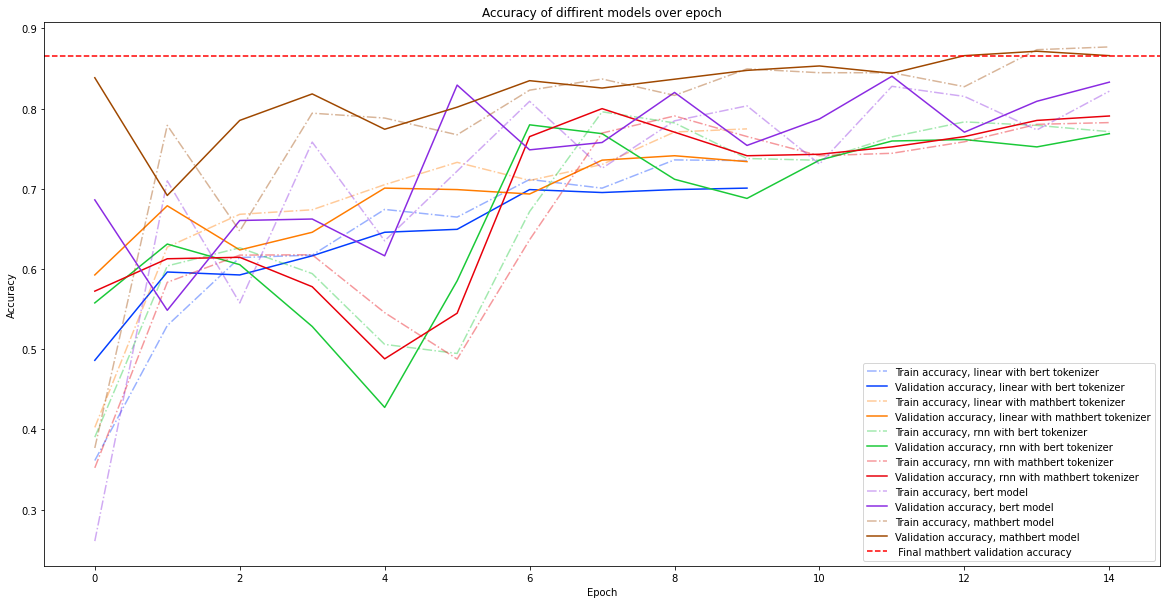

In [39]:
palette = itertools.cycle(sns.color_palette('bright'))


plt.figure(figsize = (20, 10))
for model, stat, name in zip(models, stats, model_names):
  color = next(palette)
  train_loss, train_acc, val_loss, val_acc = stat
  plt.plot(train_acc, color = color, ls = '-.', alpha = 0.4, label = f"Train accuracy, {name}")
  plt.plot(val_acc, color = color, ls = '-', label = f"Validation accuracy, {name}")

final_acc = stats[5][3][-1]
plt.axhline(final_acc, color='red', ls='--', label=' Final mathbert validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of diffirent models over epoch")
plt.legend()
plt.show()

In [40]:
final_accuracies = {}
for model, stat, name in zip(models, stats, model_names):
  train_loss, train_acc, val_loss, val_acc = stat
  final_accuracies[name]=(val_acc[-1])

In [41]:
accuracies = pd.DataFrame(np.zeros((2, 5)))
accuracies.columns = ['Tokenizer', 'Linear model', 'RNN', 'bert', 'mathbert']
accuracies['Tokenizer'] = ['Bert', 'MathBert']
accuracies['Linear model'] = [final_accuracies['linear with bert tokenizer'], final_accuracies['linear with mathbert tokenizer']]
accuracies['RNN'] = [final_accuracies['rnn with bert tokenizer'], final_accuracies['rnn with mathbert tokenizer']]
accuracies['bert'] = [final_accuracies['bert model'], '-']
accuracies['mathbert'] = ['-', final_accuracies['mathbert model']]

accuracies.set_index(['Tokenizer'])

,Linear model,RNN,bert,mathbert
Tokenizer,,,,
Bert,0.700917,0.768807,0.833028,-
MathBert,0.733945,0.790826,-,0.866055
